## Agent publisher

### Install libraries

In [32]:
%%capture --no-stderr
%pip install -U langchain_core  langchain_openai  langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [22]:
from dotenv import load_dotenv
load_dotenv()

True

In [23]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("Who is the prime minister of Poland?")

print(web_search_results["results"][0]["content"])

The incumbent and eighteenth prime minister is Donald Tusk of the Civic Platform party who replaced Mateusz Morawiecki following the 2023 Polish parliamentary


### Pretty printing helper functions

In [24]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")


def _name_and_content(msg):
    if isinstance(msg, dict):
        return msg.get("name", msg.get("role", "user")), msg.get("content", str(msg))
    if isinstance(msg, BaseMessage):
        # name może być None; type zwraca "human"/"ai"/"system"/"tool"
        name = getattr(msg, "name", None) or getattr(msg, "type", "user")
        return name, msg.content
    return "user", str(msg)


### Agent researcher

In [25]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

def research_agent_node(state):
    messages = state["messages"]
    user_request = messages[0].content  # BaseMessage OK

    search_results = web_search.invoke(user_request)
    research_content = []
    for result in search_results["results"][:3]:
        research_content.append(f"Źródło: {result['url']}\nTreść: {result['content']}\n")
    research_text = "\n---\n".join(research_content)

    research_prompt = ChatPromptTemplate.from_messages([
("system", """You're the Researcher. You have access to fragments from the 'search engine' (RESEARCH).
Your goal is to provide factual, concise facts and data supporting the topic.
Refer to the fragments and do not invent. Write concretely and briefly.
After you finish your task, respond directly to the moderator.
Reply using only the results of your work, do not include the text."""),
("user", "Topic: {topic}\n\nSearch results:\n{research_data}")

    ])

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = research_prompt | model | StrOutputParser()
    response = chain.invoke({"topic": user_request, "research_data": research_text})

    return {"messages": [{"role": "assistant", "content": response, "name": "research_agent"}]}


### Agent author

In [26]:
from langchain_core.messages import BaseMessage

def _name_and_content(msg):
    if isinstance(msg, dict):
        return msg.get("name", msg.get("role", "user")), msg.get("content", str(msg))
    if isinstance(msg, BaseMessage):
        name = getattr(msg, "name", None) or getattr(msg, "type", "user")
        return name, msg.content
    # fallback
    return "user", str(msg)


In [27]:
def author_agent_node(state):
    messages = state["messages"]
    has_critic_already_intervened = state.get("critic_marked", False)

    if has_critic_already_intervened:
        author_prompt = ChatPromptTemplate.from_messages([
("system", """You're the Expert-Editor. You have already received feedback from the Critic and you must improve your text.
Analyze the critic's comments and provide a revised version of the article that addresses their concerns.
Include all suggestions and fill in the indicated gaps. Write concretely.
After you finish your task, respond directly to the moderator.
Reply using only the results of your work, do not include the text."""),
("user", "Conversation history:\n{conversation_history}\n\nRevise the article taking into account the critic's feedback.")

        ])
    else:
        author_prompt = ChatPromptTemplate.from_messages([
("system", """You're the Expert. From the available facts, propose a practical solution/plan.
Include steps, requirements, and a minimal set of decisions. Write concretely.
After you finish your task, respond directly to the moderator.
Reply using only the results of your work, do not include the text."""),
("user", "Based on the research, create an article:\n{conversation_history}")

        ])

    conversation_history = "\n".join(
        f"{_name_and_content(m)[0]}: {_name_and_content(m)[1]}"
        for m in messages
    )

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = author_prompt | model | StrOutputParser()
    response = chain.invoke({"conversation_history": conversation_history})

    return {"messages": [{"role": "assistant", "content": response, "name": "author_agent"}]}


### Agent critic

In [28]:
def critic_agent_node(state):
    messages = state["messages"]

    conversation_history = "\n".join(
        f"{_name_and_content(m)[0]}: {_name_and_content(m)[1]}"
        for m in messages
    )

    critic_prompt = ChatPromptTemplate.from_messages([
("system", """You're the Critic. Your role is to find gaps, risks, and ambiguities in the proposal.
Ask probing questions and point out missing elements. Be constructive.
After analyzing the author's work, if you see significant gaps or problems, end your response with the words: "needs improvement"
If the work is satisfactory and does not require significant corrections, end with the words: "approved"
After you finish your task, respond directly to the moderator.
Reply using only the results of your work, do not include the text."""),
("user", "Analyze the author's work:\n{conversation_history}")
    ])

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = critic_prompt | model | StrOutputParser()
    response = chain.invoke({"conversation_history": conversation_history})

    updates = {
        "messages": [{"role": "assistant", "content": response, "name": "critic_agent"}]
    }
    if not state.get("critic_marked", False):
        updates["critic_marked"] = True

    return updates


def should_continue(state):
    last = state["messages"][-1]
    _, content = _name_and_content(last)
    content = content.lower()
    return "author_agent" if "needs improvement" in content else "end"

### Build graph

In [37]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class WorkflowState(TypedDict):
    messages: Annotated[list, add_messages]
    critic_marked: bool

supervisor = (
    StateGraph(WorkflowState)
    .add_node("research_agent", research_agent_node)
    .add_node("author_agent", author_agent_node)
    .add_node("critic_agent", critic_agent_node)
    .add_edge(START, "research_agent")
    .add_edge("research_agent", "author_agent")
    .add_edge("author_agent", "critic_agent")
    .add_conditional_edges("critic_agent", should_continue, {
        "author_agent": "author_agent",
        "end": END
    })
    .compile(debug=True)
)


### Display graph

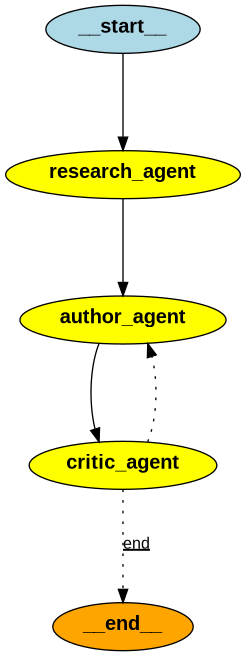

In [38]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_png()))

### Run graph and generate the article

In [39]:


for chunk in supervisor.stream(
    {
        "messages": [{
            "role": "user",
            "content": "Generate an article on the topic: How to build a 'Publisher' agent application based on the LangGraph library",
        }],
        "critic_marked": False,
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)


[values] {'messages': [HumanMessage(content="Generate an article on the topic: How to build a 'Publisher' agent application based on the LangGraph library", additional_kwargs={}, response_metadata={}, id='233e0228-4746-43e6-a5b7-08c82e480700')], 'critic_marked': False}
[updates] {'research_agent': {'messages': [{'role': 'assistant', 'content': "Building a 'Publisher' agent application based on the LangGraph library involves several steps. LangGraph, an extension of the LangChain framework, is a powerful tool that simplifies the creation of sophisticated, stateful AI agents capable of handling complex tasks. It is designed for stateful, cyclic, and multi-actor Large Language Model (LLM) applications.\n\nLangGraph was launched as a low-level agent framework and has been used by companies like LinkedIn, Uber, and Klarna to build production-ready agents. It builds upon feedback from the super popular LangChain framework and rethinks how agent frameworks should work for production.\n\nThe p